In [19]:
from typing import List, Callable

import numpy as np
import matplotlib.pyplot as plt
import einops
import scipy.stats
from scipy.stats import rankdata, multivariate_normal, norm

In [2]:
np.random.seed(13)

In [3]:
eps_x = 1
eps_y = 1
N = 10
M = 10
jitter = np.random.normal(size=(N, M, 2)) * np.array([eps_x, eps_y]).reshape(1, 1, 2)
locs_x = np.linspace(0, 10, M)
locs = einops.rearrange(
    [locs_x, np.zeros_like(locs_x)], "i j -> 1 j i"
)
labels = einops.repeat(np.arange(M), "i -> b i 1", b=N)
samples = locs + jitter


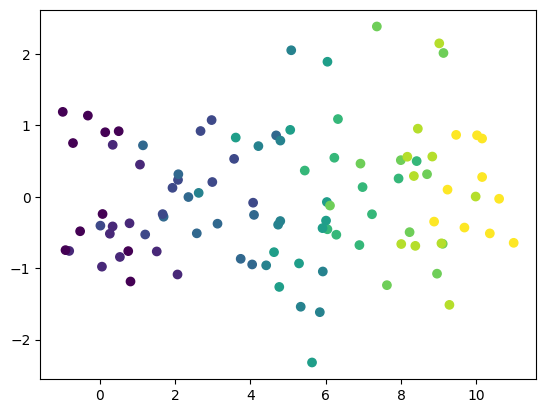

In [4]:
plt.scatter(samples[..., 0], samples[..., 1], c=labels, cmap="viridis")

In [5]:
locs.shape

(1, 10, 2)

In [221]:
def sorted_exp_sample(rates, order, n_samples=1):
    order_inv = np.argsort(order)
    rates_sorted = rates[order_inv]
    rates_summed = np.cumsum(rates_sorted[::-1])[::-1]
    sample_shifts = np.random.exponential(1/rates_summed.reshape([1, -1]), size=(n_samples, len(rates)))
    samples = np.cumsum(sample_shifts, axis=1)
    assert samples.shape == (n_samples, len(rates))
    return samples[:, order]

In [7]:
np.cumsum([1,3, 1, 2][::-1])[::-1]

array([7, 6, 3, 2])

In [8]:
np.array([0,2,1,3])[[0,2,1,3]]

array([0, 1, 2, 3])

In [9]:
sorted_exp_sample(np.array([1,1,1]), [0, 2, 1])

array([[0.09165836, 0.92171711, 0.87511528]])

In [10]:
def infer_rates(samples: List[np.ndarray], n_iter=3):
    rates = np.ones(len(samples))
    flat_samples = np.concatenate(samples)
    order = rankdata(flat_samples, method="ordinal") - 1
    def flatten_rates(rates):
        return np.concatenate([rates[i] * np.ones(len(samples[i])) for i in range(len(samples))])
    for _ in range(n_iter):
        flat_rates = flatten_rates(rates)
        latent_samples = sorted_exp_sample(flat_rates, order, n_samples=1)[0,...]
        new_rates = []
        start = 0
        end = len(samples[0])
        for i in range(len(samples)):
            new_rates.append(len(samples[i]) / (latent_samples[start:end].sum() + 1e-6))
            start = end
            end += len(samples[i])
        rates = np.array(new_rates)
    return rates


15.033261958623823


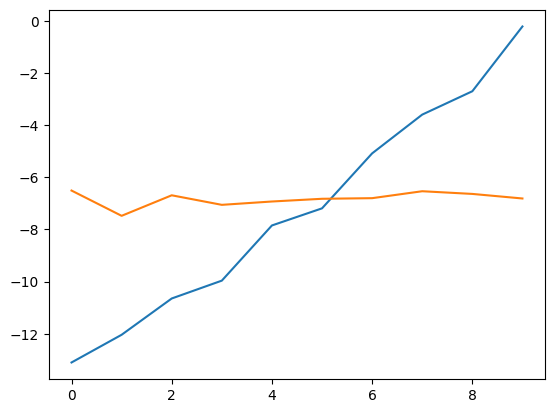

In [11]:
inferred_x = infer_rates([samples[:, i, 0] for i in range(M)], n_iter=1000)
inferred_y = infer_rates([samples[:, i, 1] for i in range(M)], n_iter=1000)
plt.plot(-np.log(inferred_x))
plt.plot(-np.log(inferred_y))
print(np.log(inferred_x).std()/np.log(inferred_y).std())

15.244688099335315


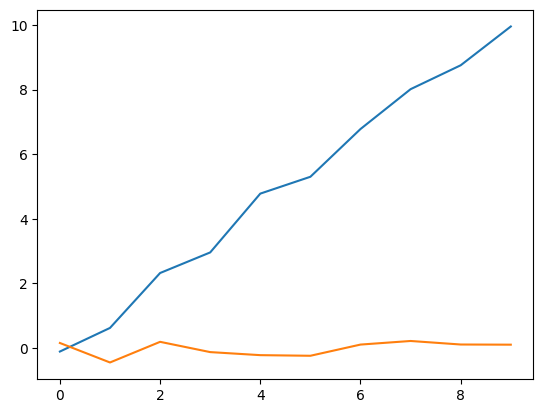

In [12]:
mean_x = np.array([samples[:, i, 0].mean() for i in range(M)])
mean_y = np.array([samples[:, i, 1].mean() for i in range(M)])
plt.plot(mean_x)
plt.plot(mean_y)
print(mean_x.std()/mean_y.std())

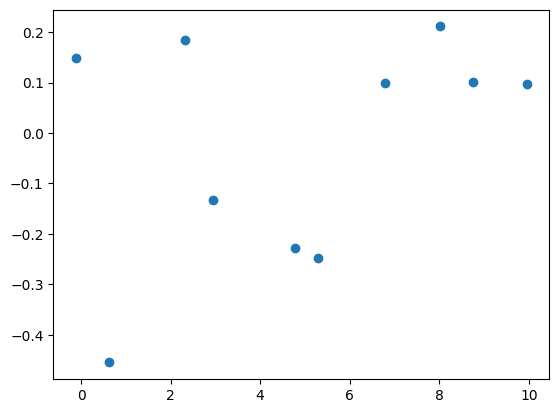

In [337]:
plt.scatter(mean_x, mean_y)

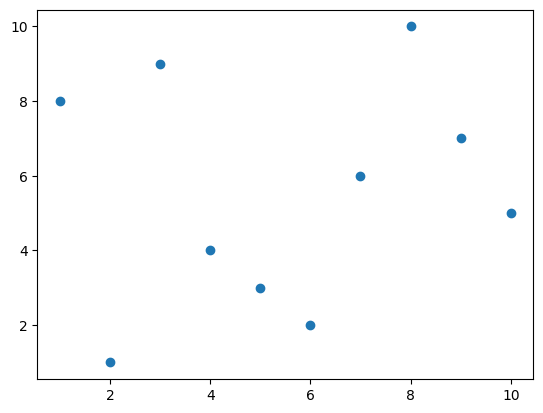

In [338]:
plt.scatter(rankdata(mean_x), rankdata(mean_y))

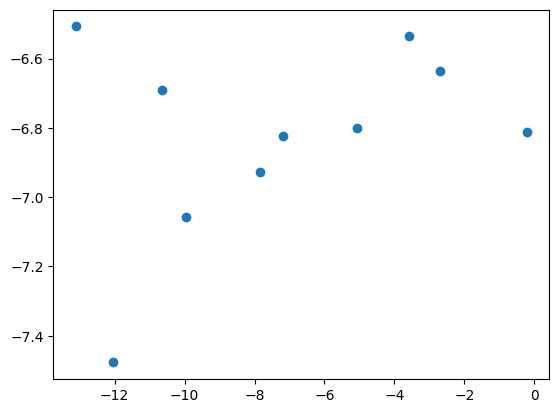

In [13]:
plt.scatter(-np.log(inferred_x), -np.log(inferred_y))
# plt.plot(inferred)

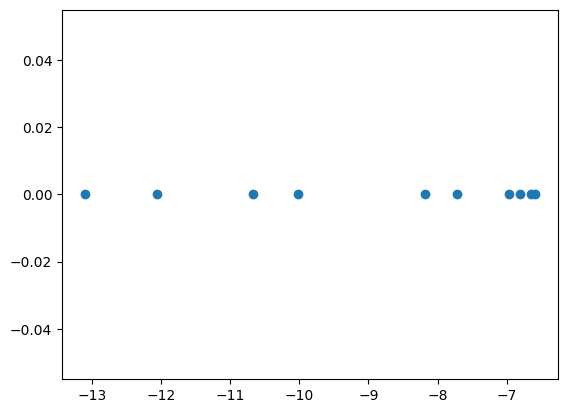

In [14]:
plt.scatter(-np.log(inferred_x+inferred_y), np.zeros_like(inferred_x))

In [15]:
np.argsort(-np.log(inferred_x+inferred_y))

array([0, 1, 2, 3, 4, 5, 6, 9, 8, 7])

In [16]:
np.argsort(mean_x+mean_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [277]:
def optimize_function_deterministic(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000, alpha=0.1):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = None
    cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
    for _ in range(n_evals):
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            if mean is None:
                weights = latent_samples.reshape([-1, 1])
            else:
                weights = (latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
                weights /= weights.sum()
            mean = (weights * xs).sum(axis=0)
            new_cov = (1-alpha)*(
                (xs - mean[None, :]).T
                @ (weights * (xs - mean[None, :]))
            )+alpha*cov
            rv = multivariate_normal(mean=mean, cov=new_cov, allow_singular=False)
            rates = rv.pdf(xs)
        cov = new_cov
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys

def optimize_function(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = None
    cov = None
    for _ in range(n_evals):
        print("** iter **")
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            weights = latent_samples.reshape([-1, 1]) / latent_samples.sum()
            if mean is None:
                mean = (weights * xs).sum(axis=0)
                cov = (
                    (xs - mean[None, :]).T
                    @ (weights * (xs - mean[None, :]))
                )
            else:
                i = np.argmax(np.log(weights)+np.random.gumbel(size=len(weights)))
                x_ = xs[i,:]
                scipy.stats.invwishart(df=len(xs), scale=cov+x_).rvs()
                mean = np.zeros_like(xs[0])
                cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
                new_mean = rv.rvs(size=1).flatten()
                weights = (latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
                weights /= weights.sum()
                print(list(zip(xs.flatten().tolist(), latent_samples.flatten().tolist(), weights.flatten().tolist())))
                mean = (weights * xs).sum(axis=0)
                cov = (
                    (xs - mean[None, :]).T
                    @ (weights * (xs - mean[None, :]))
                )
                rv = multivariate_normal(mean=mean, cov=cov, allow_singular=False)
                rates = rv.pdf(xs)
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys


def optimize_function_deterministic(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = np.zeros_like(xs[0])
    cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
    for _ in range(n_evals):
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            weights = 1-(latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
            weights /= weights.sum()
            mean = (weights * xs).sum(axis=0)
            cov = (
                (xs - mean[None, :]).T
                @ (weights * (xs - mean[None, :]))
            )
            rv = multivariate_normal(mean=mean, cov=cov, allow_singular=False)
            rates = rv.pdf(xs)
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys

In [278]:
def function(x):
    return -np.sum(x**2)

In [279]:
rv, xs, ys = optimize_function_deterministic(function, [np.array([10]), np.array([-12]), np.array([5])], n_evals=100, n_iter=100)

ValueError: The input matrix must be symmetric positive semidefinite.

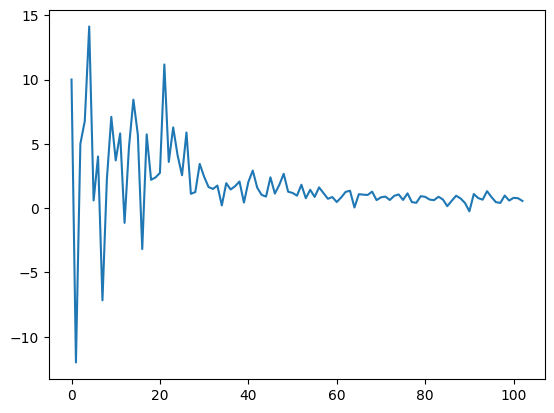

In [274]:
plt.plot(xs)

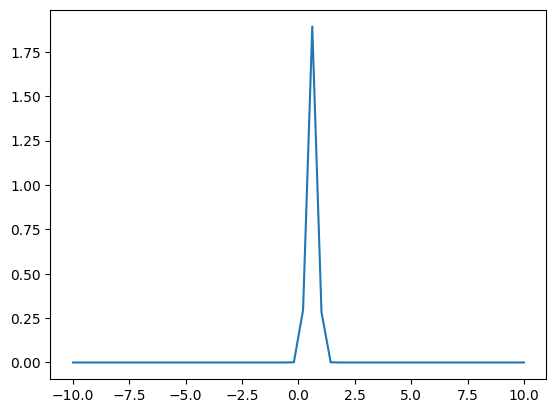

In [275]:
plt.plot(np.linspace(-10, 10), rv.pdf(np.linspace(-10, 10)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

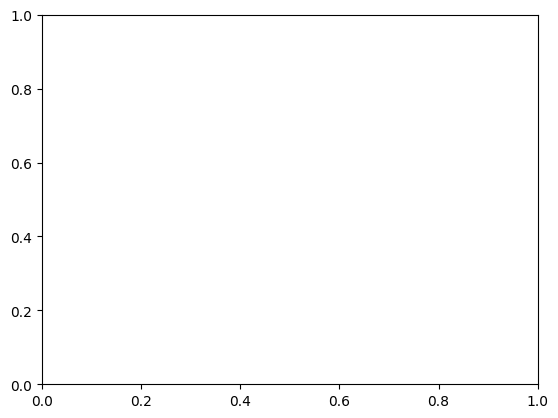

In [276]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

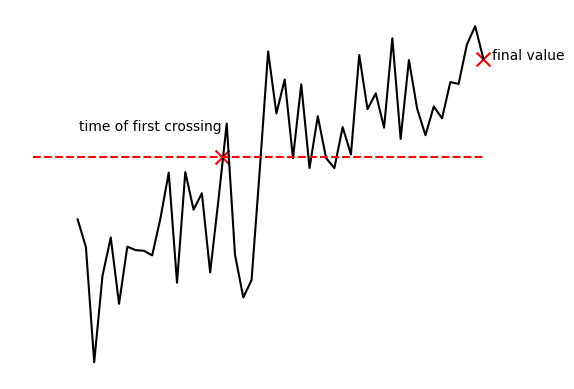

In [330]:
np.random.seed(10)
time = np.linspace(1, 10)
y_mean = time*.5
y = y_mean + np.random.normal(size=len(time))
y_max = y_mean + 1
plt.box(False)

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.plot(time, y, color="black")
plt.hlines(3, 0, 10, color="red", ls="--")
plt.text(4.2, 3.5, "time of first crossing", horizontalalignment='right')
# Place an x at the point (5, 5)
plt.scatter(4.2, 3, color="red", s=100, marker="x")

plt.text(10.2, y[-1], "final value", horizontalalignment='left')
# Place an x at the point (5, 5)
plt.scatter(10, y[-1], color="red", s=100, marker="x")

Text(0.5, 1.0, 'Model dynamics')

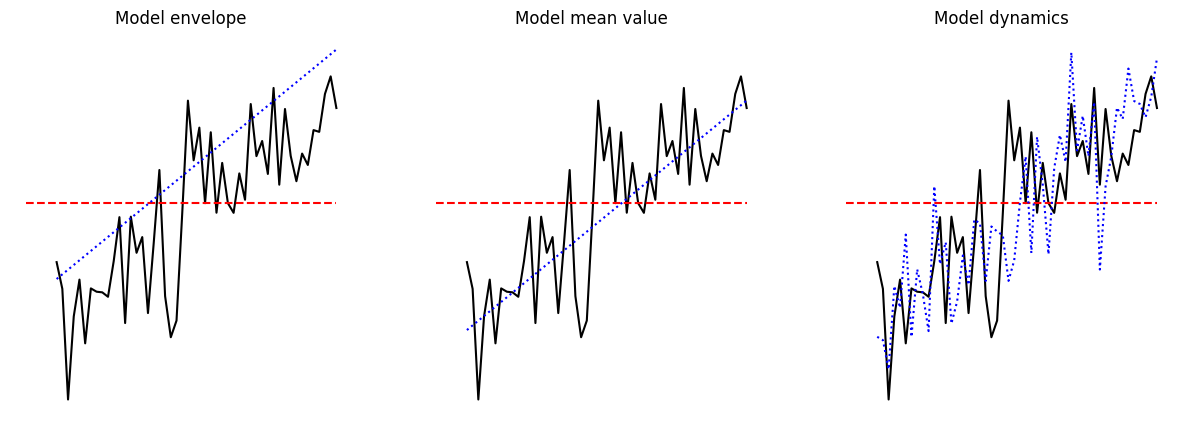

In [336]:
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.plot(time, y, color="black")
    ax.hlines(3, 0, 10, color="red", ls="--")
    ax.set_axis_off()
    
    ax.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 

axs[0].plot(time, y_max, color="blue", ls=":")
axs[0].set_title("Model envelope")
axs[1].plot(time, y_mean, color="blue", ls=":")
axs[1].set_title("Model mean value")
axs[2].plot(time, y_mean + np.random.normal(size=len(time)), color="blue", ls=":")
axs[2].set_title("Model dynamics")